In [1]:
RANDOM_SEED = 42

In [2]:
path_ = "Scalograms-stacked-wavdec"

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
#Preparing images for model training --- image size = 256 x 256
train_batch = 64
test_batch = 64
train_set= image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='binary',
                                batch_size=train_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.2,
                                subset='training')
                                
val_set =  image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='binary',
                                batch_size=test_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.2,
                                subset='validation')

Found 1680 files belonging to 2 classes.
Using 1344 files for training.
Found 1680 files belonging to 2 classes.
Using 336 files for validation.


In [5]:
test_ds_size = int(int(val_set.__len__())*0.5) # test-test set has 478 images and val set has 1647 images == # 9563 * 0.05
test_test_set = val_set.take(test_ds_size)
test_set = val_set.skip(test_ds_size)

In [6]:
print(val_set.__len__(), train_set.__len__(), test_set.__len__(), test_test_set.__len__(), sep='\n')

tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(21, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


In [7]:
from keras.layers import Flatten, Dense, Flatten
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
#from keras.optimizers import gradient_descent_v2 
from keras import regularizers, initializers
from livelossplot import PlotLossesKeras
from tensorflow.keras.applications.vgg16 import VGG16

In [8]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = vgg16.layers[-1].output
output = Flatten()(output)
vgg16 = Model(vgg16.input, output)
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
model_1 = Sequential()

model_1.add(vgg16)
model_1.add(Dense(64,activation='relu', input_dim=(256,256,3),  kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.5)))
model_1.add(Dense(64,activation='relu', kernel_regularizer=regularizers.L2(0.5)))
model_1.add(Dense(1,activation='sigmoid'))

model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','Recall','Precision','AUC'])   

In [10]:
filepath = "Models/scalograms-TL-vgg16-checkpoints/scalograms-TL-l2-05-vgg16-model-t3.h5"

callbacks = [#EarlyStopping(monitor='val_accuracy', patience=4),
            ModelCheckpoint(filepath=filepath, monitor="val_accuracy", mode='max', save_best_only=True),
            PlotLossesKeras()]

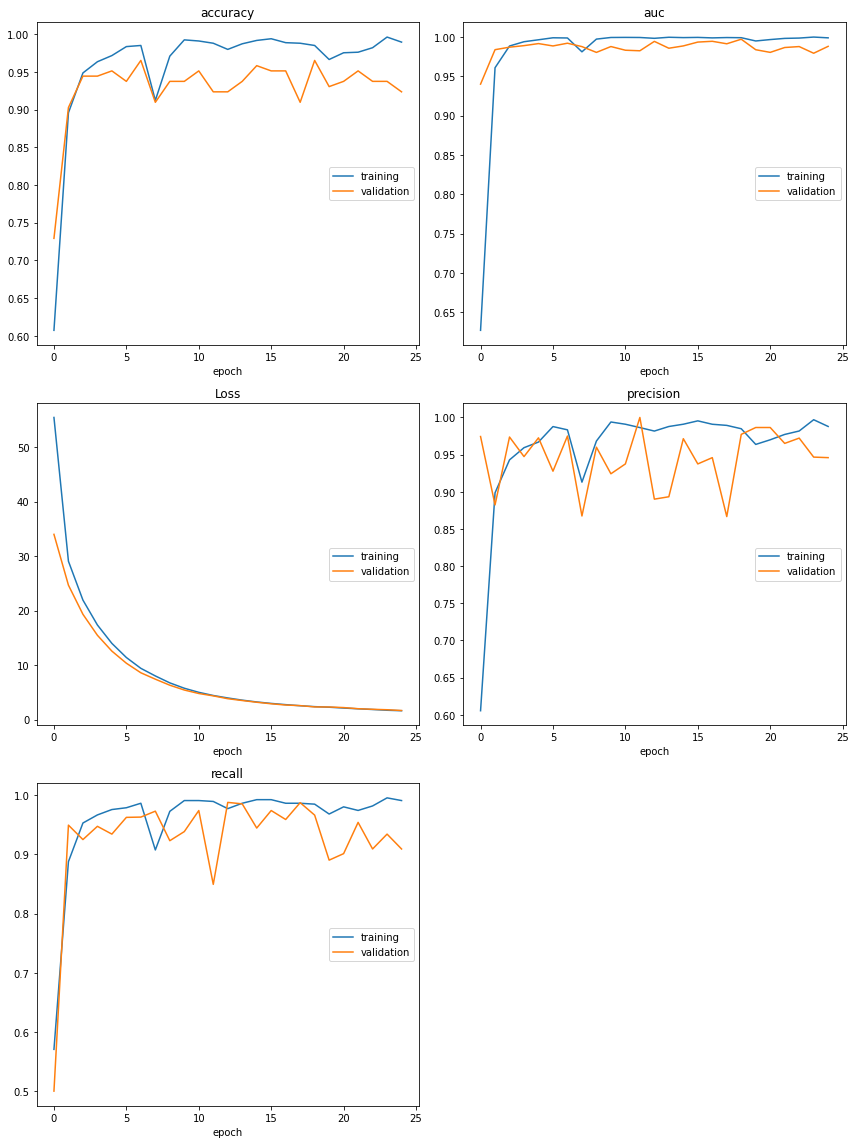

accuracy
	training         	 (min:    0.607, max:    0.996, cur:    0.990)
	validation       	 (min:    0.729, max:    0.965, cur:    0.924)
auc
	training         	 (min:    0.627, max:    1.000, cur:    0.999)
	validation       	 (min:    0.940, max:    0.997, cur:    0.988)
Loss
	training         	 (min:    1.625, max:   55.417, cur:    1.625)
	validation       	 (min:    1.667, max:   33.979, cur:    1.667)
precision
	training         	 (min:    0.605, max:    0.997, cur:    0.988)
	validation       	 (min:    0.867, max:    1.000, cur:    0.946)
recall
	training         	 (min:    0.571, max:    0.995, cur:    0.991)
	validation       	 (min:    0.500, max:    0.988, cur:    0.909)
21/21 [==============================] - 14s 664ms/step - loss: 1.6249 - accuracy: 0.9896 - recall: 0.9909 - precision: 0.9879 - auc: 0.9989 - val_loss: 1.6674 - val_accuracy: 0.9236 - val_recall: 0.9091 - val_precision: 0.9459 - val_auc: 0.9881


In [11]:
h = model_1.fit(train_set,
                epochs=25,
                #steps_per_epoch=64,
                validation_data=test_set,
                #validation_steps=32,
                callbacks=callbacks
                )

In [12]:
import pandas as pd

pd.DataFrame.from_dict(h.history).to_csv(filepath[:-2] + 'csv' , index=False)
#data=pd.read_csv("Models/scalogram-base-model-checkpoints/scalogram-base-model-1.csv")

In [13]:
model_1.evaluate(test_test_set)

KeyboardInterrupt: 